# Gomoku Game Analysis

This Jupyter notebook is dedicated to analyzing the performance of various AI strategies in the game of Gomoku. We'll explore the feature impact on game outcomes, evaluate the effectiveness of different AI patterns, and prepare the data for model training.

## Setup

First, we import necessary libraries and load the data.

In [4]:
import pandas as pd
from pathlib import Path
from gameData import GameManager  # Adjust the import path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Ensure that GameManager is loading from the correct path
manager = GameManager.load_state()  # Use absolute path

# Function to extract data from GameManager
def extract_data(games):
    game_details = []
    for game_index, game in enumerate(games):
        for move in game.moves:
            move_details = {
                'game_number': game_index + 1,
                'move_number': game.moves.index(move) + 1,
                'player': move['player'],
                'position': move['position'],
                'score': move['score'],
                'distance_from_center': move['distance_from_center'],
                'position_x': move.get('position_x', 0),
                'position_y': move.get('position_y', 0),
                'local_ai_stones': move.get('local_ai_stones', 0),
                'local_enemy_stones': move.get('local_enemy_stones', 0),
                'aggressive_sequence': move.get('aggressive_sequence', 0),
                'defensive_pressure': move.get('defensive_pressure', 0),
                'total_opportunities': move.get('total_opportunities', 0),
                'total_threats': move.get('total_threats', 0),
                **{key: move.get(key, 0) for key in move.keys() if key.startswith('minor_') or key.startswith('moderate_') or key.startswith('major_') or key.startswith('critical_') or key.startswith('win_') or key.startswith('lose_')}
            }
            game_details.append(move_details)
    return game_details

# Extract data
data = extract_data(manager.games)

# Create DataFrame
df = pd.DataFrame(data)

### DATA PROCESSING
# --------------------------------------------------------------------------------

# Adjusting feature calculations
df['total_local_stones'] = df['local_ai_stones'] + df['local_enemy_stones']
df.drop(['local_ai_stones', 'local_enemy_stones'], axis=1, inplace=True)

# Drop 'minor_threat'
df.drop(['minor_threat'], axis=1, inplace=True)

# Define the data directory
data_dir = Path('../data')

# Save the DataFrame to a CSV file for easy access
# Filter to only include moves made by the Black player
df_black = df[df['player'] == 'Black']

# Save the DataFrame to a CSV file for easy access and model training
csv_path = data_dir / 'game_data_black.csv'
df_black.to_csv(csv_path, index=False)

# Load and style for review
df_loaded_black = pd.read_csv(csv_path)
styled_df_black = df_loaded_black.head().style.background_gradient(cmap='viridis')  # Visual styling
display(styled_df_black)


,game_number,move_number,player,position,score,distance_from_center,position_x,position_y,aggressive_sequence,defensive_pressure,total_opportunities,total_threats,minor_opportunity,moderate_opportunity,major_opportunity,critical_open,win_sequence,moderate_threat,major_threat,critical_threat,lose_sequence,total_local_stones
0,1,1,Black,"(7, 7)",10,0,7,7,0,0,4,4,4,0,0,0,0,0,0,0,0,1
1,1,3,Black,"(7, 6)",730,1,7,6,0,0,3,3,2,1,0,0,0,1,0,0,0,3
2,1,5,Black,"(5, 7)",1560,2,5,7,0,0,3,5,3,0,0,0,0,0,1,0,0,5
3,1,7,Black,"(6, 5)",5200,3,6,5,0,0,2,4,1,1,0,0,0,1,1,0,0,7
4,1,9,Black,"(5, 6)",810,3,5,6,0,0,2,2,0,2,0,0,0,1,0,0,0,9


## Data Visualization

Visualizing the distribution of scores and the impact of different AI patterns on the game's outcome.


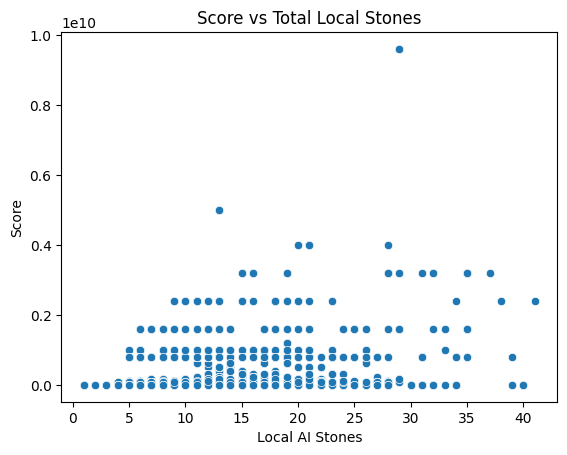

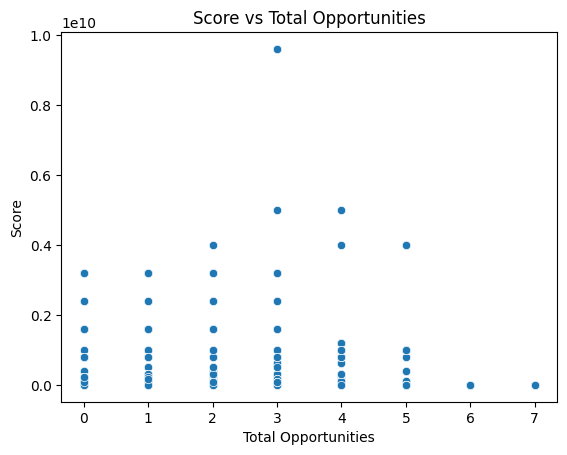

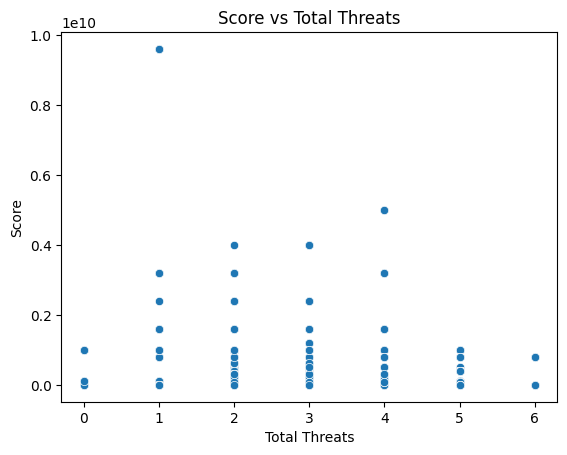

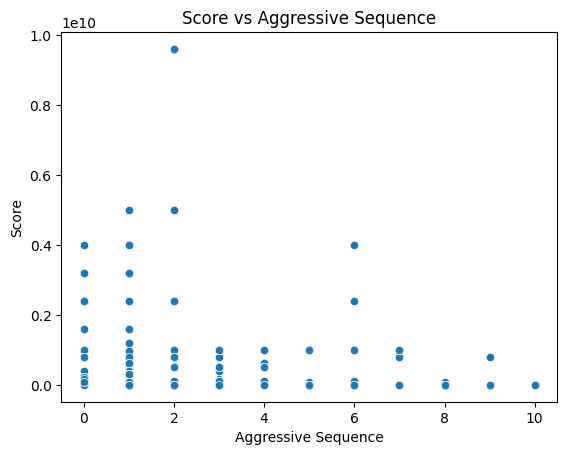

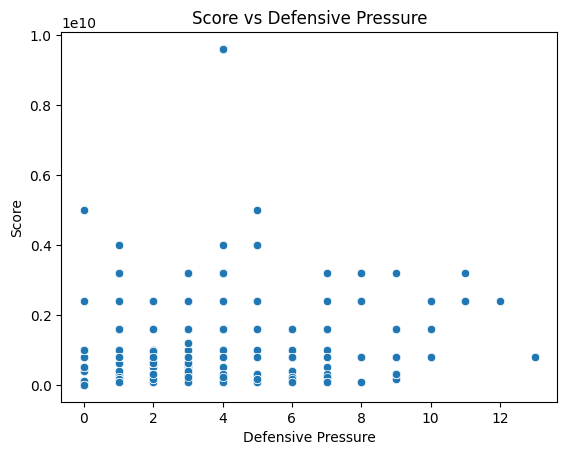

In [6]:
# Load the DataFrame for black player data
df = pd.read_csv(data_dir / 'game_data_black.csv')

# Scatter plot of score vs Local AI Stones
sns.scatterplot(data=df, x='total_local_stones', y='score')
plt.title('Score vs Total Local Stones')
plt.xlabel('Local AI Stones')
plt.ylabel('Score')
plt.show()


# Scatter plot of score vs Total Opportunities
sns.scatterplot(data=df, x='total_opportunities', y='score')
plt.title('Score vs Total Opportunities')
plt.xlabel('Total Opportunities')
plt.ylabel('Score')
plt.show()

# Scatter plot of score vs Total Threats
sns.scatterplot(data=df, x='total_threats', y='score')
plt.title('Score vs Total Threats')
plt.xlabel('Total Threats')
plt.ylabel('Score')
plt.show()

# Scatter plot of score vs Aggressive Sequence
sns.scatterplot(data=df, x='aggressive_sequence', y='score')
plt.title('Score vs Aggressive Sequence')
plt.xlabel('Aggressive Sequence')
plt.ylabel('Score')
plt.show()

# Scatter plot of score vs Defensive Pressure
sns.scatterplot(data=df, x='defensive_pressure', y='score')
plt.title('Score vs Defensive Pressure')
plt.xlabel('Defensive Pressure')
plt.ylabel('Score')
plt.show()

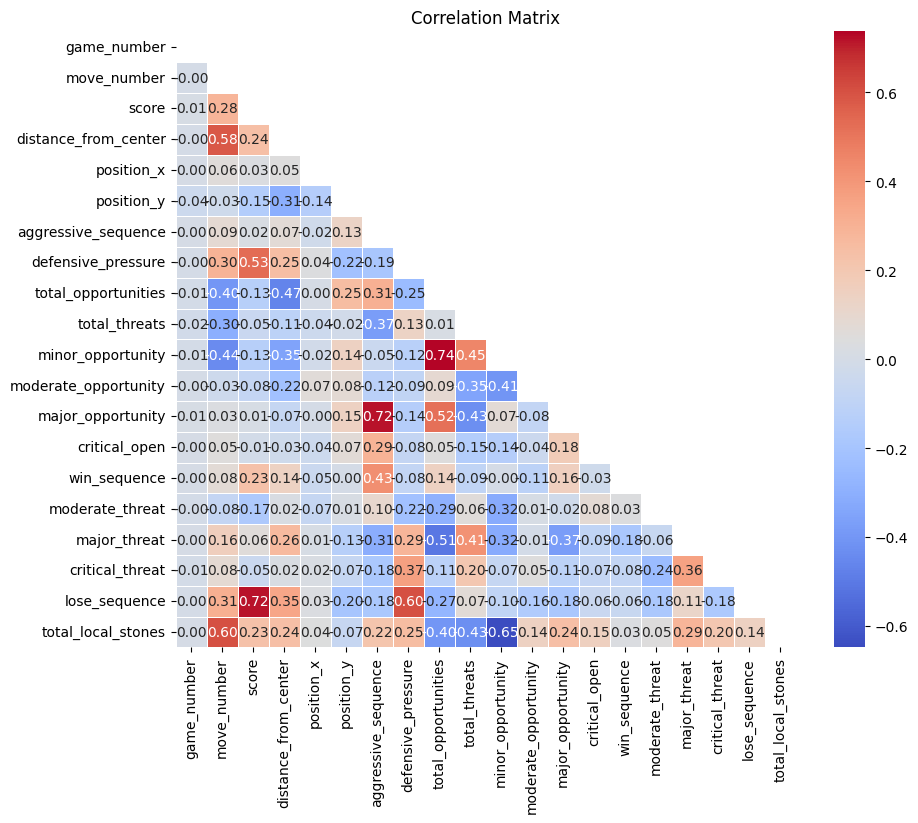

In [79]:
# Compute the correlation matrix
corr = df_loaded_black.select_dtypes(include=[np.number]).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", linewidths=.5, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


## Training

Start training a regression tree model

GradientBoosting - Mean Squared Error: 2.2810572598522124e+16
GradientBoosting - Cross-Validation MSE: 2.746913754855956e+16


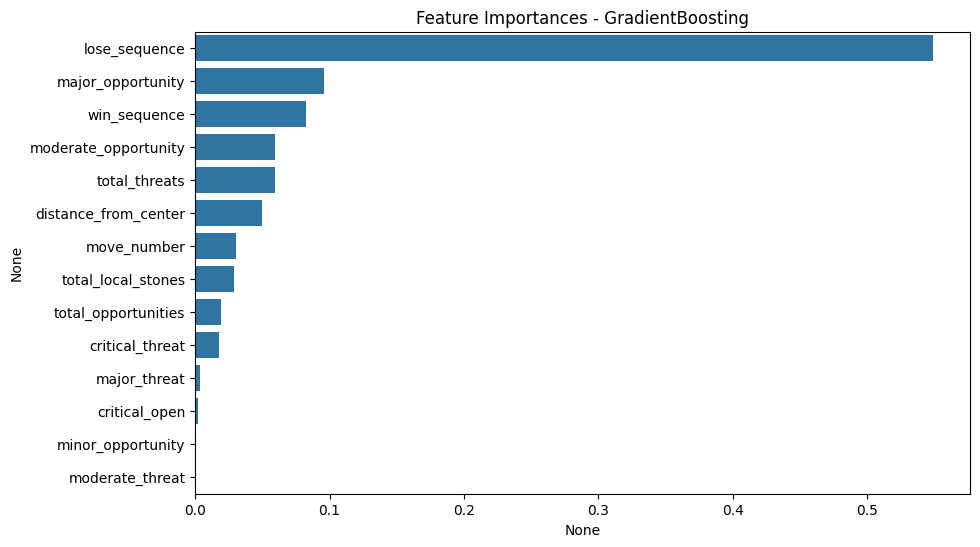

RandomForest - Mean Squared Error: 5783771848864276.0
RandomForest - Cross-Validation MSE: 1.054004631816787e+16


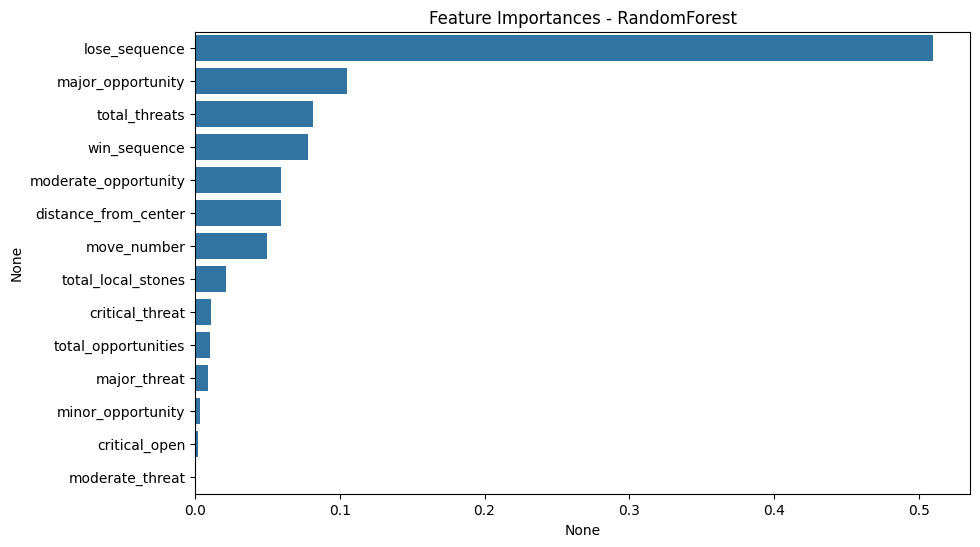

DecisionTree - Mean Squared Error: 6574836611254912.0
DecisionTree - Cross-Validation MSE: 1.6309541893614406e+16


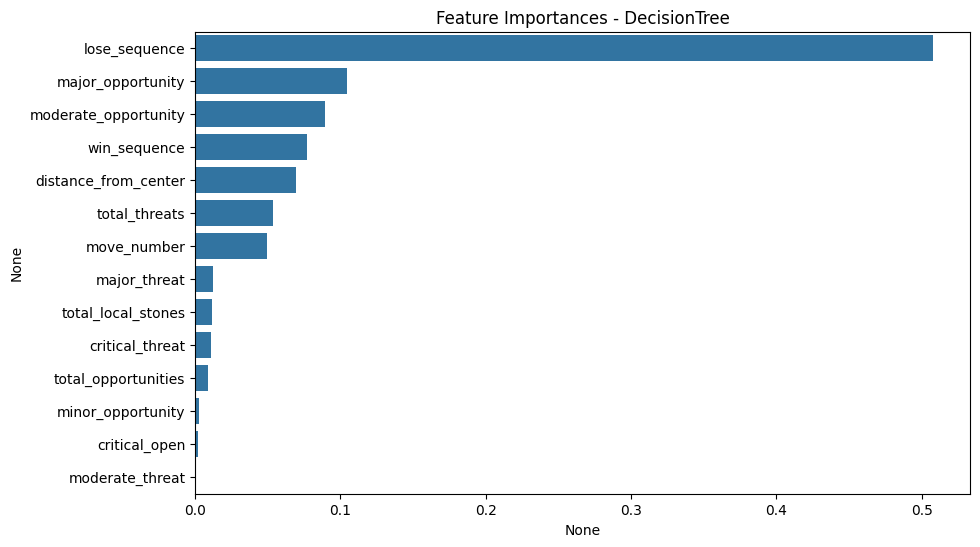

In [11]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import joblib

# Load the cleaned data
df = pd.read_csv(data_dir / 'game_data_black.csv')

# Drop the highly correlated features and position features for experimentation
# df = df.drop(columns=['aggressive_sequence', 'lose_sequence', 'minor_opportunity'])
df = df.drop(columns=['position_x', 'position_y', 'aggressive_sequence', 'defensive_pressure'])

# Normalize the scores
# scaler = StandardScaler()
# df['score'] = scaler.fit_transform(df[['score']])

# Separate the features and the target variable
X = df.drop(columns=['score', 'player', 'position', 'game_number'])
y = df['score']

# Normalize the features
# numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
# X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'DecisionTree': DecisionTreeRegressor(random_state=42)
}

# Dictionary to store MSE for each model
mse_scores = {}
cv_scores = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)
    mse_scores[name] = mse
    
    # Cross-validation
    cv_score = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    cv_scores[name] = -cv_score.mean()
    
    print(f"{name} - Mean Squared Error: {mse}")
    print(f"{name} - Cross-Validation MSE: {-cv_score.mean()}")

    # Save the Random Forest model
    if name == 'RandomForest':
        joblib.dump(model, data_dir / 'random_forest_gomoku.pkl')

    # Visualize the feature importances for each model
    if hasattr(model, 'feature_importances_'):
        feature_importances = pd.Series(model.feature_importances_, index=X.columns)
        feature_importances = feature_importances.sort_values(ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=feature_importances, y=feature_importances.index)
        plt.title(f"Feature Importances - {name}")
        plt.show()


## Conclusion

This initial analysis helps us to understand the effectiveness of our AI in generating strategic moves and provides a foundation for further detailed machine learning modeling.
